In [1]:
%load_ext nb_black

import anndata
import cellplots as cp
import larry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import scipy.stats
import seaborn as sns
import torch

from typing import Any, Dict, Optional

/home/mvinyard/.anaconda3/envs/sdq-dev/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
scdiffeq.scdiffeq - INFO - Logs for scdiffeq will be saved to: /home/mvinyard/.log_cache/scdiffeq.log


<IPython.core.display.Javascript object>

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)
larry_cmap = larry.pl.InVitroColorMap()._dict

PCA = sdq.io.read_pickle("/home/mvinyard/data/pca_model.pkl")
UMAP = sdq.io.read_pickle("/home/mvinyard/data/umap_model.pkl")

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


/home/mvinyard/.anaconda3/envs/sdq-dev/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<IPython.core.display.Javascript object>

In [3]:
project_path = "/home/mvinyard/experiments/LARRY.full_dataset/v1/LightningSDE-FixedPotential-RegularizedVelocityRatio/"
project = sdq.io.Project(path=project_path)
best_ckpts = sdq_an.parsers.summarize_best_checkpoints(project)
best_ckpts

,train,test,ckpt_path,epoch
version_0,0.571656,0.551804,/home/mvinyard/experiments/LARRY.full_dataset/...,2500
version_1,0.541401,0.465658,/home/mvinyard/experiments/LARRY.full_dataset/...,1706
version_2,0.547771,0.499418,/home/mvinyard/experiments/LARRY.full_dataset/...,1238
version_3,0.496815,0.504075,/home/mvinyard/experiments/LARRY.full_dataset/...,1245
version_4,0.562102,0.522701,/home/mvinyard/experiments/LARRY.full_dataset/...,1662


<IPython.core.display.Javascript object>

In [4]:
Perturbed = {}
for version, row in best_ckpts.iterrows():
    model = sdq.io.load_model(adata=adata, ckpt_path=row["ckpt_path"])
    break

 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.


<IPython.core.display.Javascript object>

In [21]:
result = sdq.tl.perturb_scan_z_range(
    adata=adata,
    model=model,
    obs_key="Cell type annotation",
    subset_key="Cell type annotation",
    subset_val="Undifferentiated",
    genes=["Cebpe", "Dach1", "Lmo4", "Mxd1"],
    t_sim=torch.linspace(2, 6, 41),
    z_range=np.linspace(-10, 10, 9),
    PCA=PCA,
    N=200,
    replicates=10,
    seed=0,
)

scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=-10.0)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=-7.5)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=-5.0)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=-2.5)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=0.0)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=2.5)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=5.0)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=7.5)
scdiffeq.tools._perturb_scan_z_range - INFO - Perturbed 4 genes (Z=10.0)


<IPython.core.display.Javascript object>

In [34]:
mon = {key: val.prtb.loc["Monocyte"].values.tolist() for key, val in result.items()}
neu = {key: val.prtb.loc["Neutrophil"].values.tolist() for key, val in result.items()}

<IPython.core.display.Javascript object>

In [41]:
import ABCParse

<IPython.core.display.Javascript object>

In [43]:
from typing import List, Optional

<IPython.core.display.Javascript object>

In [44]:
class StylishBoxPlot(ABCParse.ABCParse):
    def __init__(
        self,
        colors: Optional[List[str]] = None,
        widths: Optional[float] = None,
        scatter_kw={
            "alpha": 0.8,
            "s": 25,
        },
        *args,
        **kwargs
    ):
        self.__parse__(locals())

    @property
    def colors(self):
        if not hasattr(self, "_colors") or self._colors is None:
            self._colors = list(cm.tab20.colors)
        return self._colors

    def _background_scatter(self, ax, data):
        for en, (key, val) in enumerate(data.items()):

            x = [key] * len(val)

            if len(x) > 1:
                x_vals = en + 1 + (np.random.random(len(x)) - 0.5) / 5
            else:
                x_vals = en + 1

            ax.scatter(
                x_vals,
                val,
                color=self.colors[en],
                zorder=0,
                ec="None",
                rasterized=False,
                **self._scatter_kw,
            )

    def _background_boxplot(self, ax, data):

        x = list(data.keys())
        y = list(data.values())

        x = np.arange(len(y)) + 1

        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=True,
            showfliers=False,
            meanline=True,
            zorder=1,
            widths=self._widths,
        )
        for median in bp["medians"]:
            median.set_visible(False)
        for en, mean in enumerate(bp["means"]):
            mean.set_c(self.colors[en])

        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor(self.colors[en])
            box.set_alpha(0.2)

        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c("None")

        for en, cap in enumerate(bp["caps"]):
            cap.set_c("None")

    def _foreground_boxplot(self, ax, data):

        y = list(data.values())
        x = list(data.keys())
        x = np.arange(len(y)) + 1
        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=False,
            showfliers=False,
            meanline=False,
            zorder=2,
            widths=self._widths,
        )
        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor("None")
            box.set_edgecolor(self.colors[en])

        colors_ = np.repeat(
            np.array(self.colors), 2, axis=0
        )  # list(np.repeat(self.colors, 2))
        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c(colors_[en])

        for en, cap in enumerate(bp["caps"]):
            cap.set_c(colors_[en])

        for median in bp["medians"]:
            median.set_visible(False)

    def __call__(self, ax, data, *args, **kwargs):

        self.__update__(locals())

        try:
            self._background_scatter(ax, data)
        except:
            print(data)
        self._background_boxplot(ax, data)
        self._foreground_boxplot(ax, data)

<IPython.core.display.Javascript object>

In [55]:
x = [0, 2.5, 5, 7.5, 10, -2.5, -5, 7.5, -10]
mon_x = {xi: mon[xi] for xi in x}
neu_x = {xi: neu[xi] for xi in x}

<IPython.core.display.Javascript object>

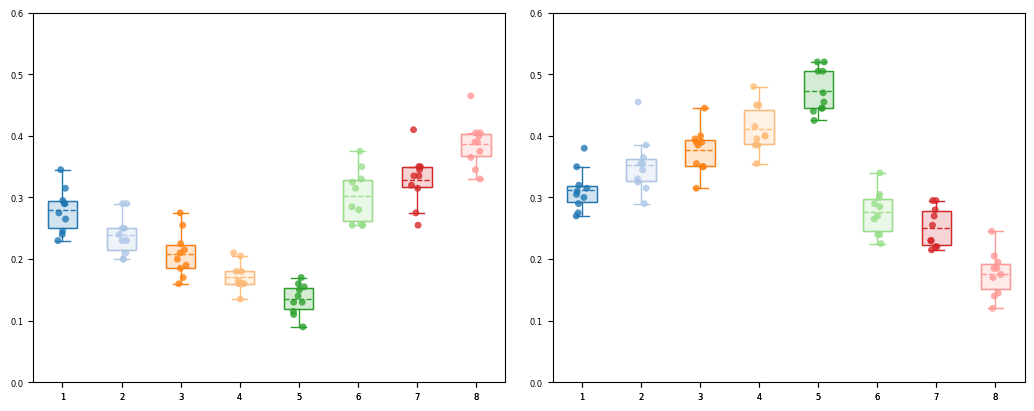

<IPython.core.display.Javascript object>

In [60]:
fig, axes = cp.plot(nplots=2, ncols=2, wspace=0.1)
bp = StylishBoxPlot()
bp(ax=axes[0], data=mon_x)
bp = StylishBoxPlot()
bp(ax=axes[1], data=neu_x)
for ax in axes:
    ax.set_ylim(0, 0.6)
plt.savefig("Figure3CD.LARRY.z_scan.tf_perturbation.svg", dpi=500)